My good friend __[Zane Blanton](https://github.com/zscore)__ commented on how interesting the graph of USA unemployment rate looked. So inspired by him I decided to start up this notebook to study it with some of the tools that I'm aware of.

We'll use pandas because it's a great library for working with data. And matplotlib to plot graphs, I'm setting some stuff here to make the graphs bigger and nicer.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 10]
plt.style.use(['fivethirtyeight'])

Let's download the data and put it in a pandas dataframe. Yes, pandas already has a function to download *and* load the CSV with just an URL! Neat.

In [2]:
UNRATE_URL = ('https://fred.stlouisfed.org/graph/fredgraph.csv?chart_type=line'
              '&recession_bars=on&log_scales=&bgcolor=%23e1e9f0&graph_bgcolor='
              '%23ffffff&fo=Open+Sans&ts=12&tts=12&txtcolor=%23444444&show_leg'
              'end=yes&show_axis_titles=yes&drp=0&cosd=1948-01-01&coed=2017-06'
              '-01&height=450&stacking=&range=&mode=fred&id=UNRATE&transformat'
              'ion=lin&nd=1948-01-01&ost=-99999&oet=99999&lsv=&lev=&mma=0&fml='
              'a&fgst=lin&fgsnd=2009-06-01&fq=Monthly&fam=avg&vintage_date=&re'
              'vision_date=&line_color=%234572a7&line_style=solid&lw=2&scale=l'
              'eft&mark_type=none&mw=2&width=968')
df = pd.read_csv(UNRATE_URL, parse_dates=['DATE'], index_col=['DATE'])

Pandas dataframe objects come with methods hooked up with matplotlib and we can tweak stuff inside the cell, jupyter notebook will deal with it before showing the plot.

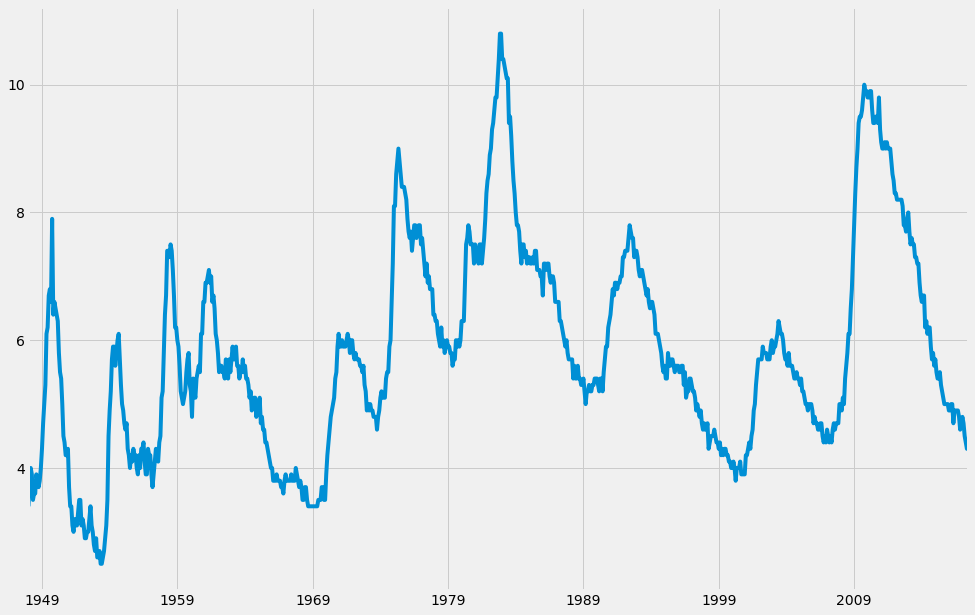

In [3]:
ax = df['UNRATE'].plot()
ax.get_xaxis().label.set_visible(False)

As you can see the graph is clearly cyclical, which reminds me of... You know... Crisis theory.

You see, capitalism has a cyclical behaviour. It's much like a prey-predator dynamic.

So considering this... Are we close to the unemployment rate rising again? Looking at the graph it sure feels like it, but let's try some things!

First let's calculate the moving average of the data (aka the rolling mean). It's a pretty straightforward idea, it's just about calculating the average for a "window" of time, say 12 months here. And keep "rolling" the window to get a new time series.

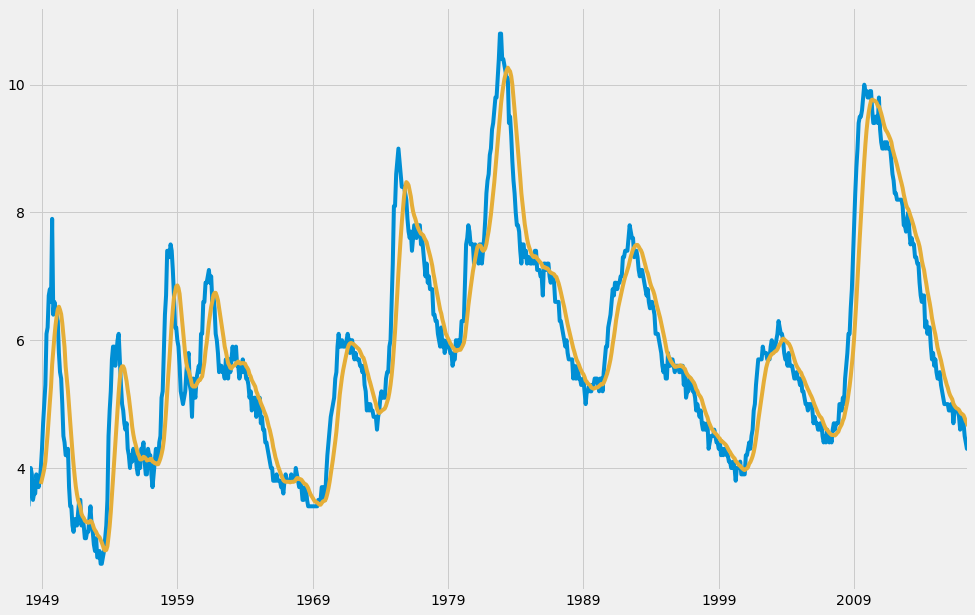

In [4]:
df['rmean'] = df['UNRATE'].rolling(window=12).mean()

ax = df['UNRATE'].plot()
df['rmean'].plot(color='C8')
ax.get_xaxis().label.set_visible(False)

Yellow here is the moving average, as you can see it's a smoothed version of the original data with a slight lag.

Some people intepret the moving average as a representation of the "correct" value of the data. That means that substantial deviations from it eventually result in a return to the correct value, in other words, a return to the moving average.

Stocks aficionados came up with a way to detect those significant deviations in moving averages which is called Bollinger bands. They use it as trading signals to buy or sell stocks.

Yes, I'm aware that there's some unrigorous magical thinking in this approach, but I feel like indicators are always interesting, even when they're built over a shoddy basis.

To draw the Bollinger bands first we need to calculate the moving standard deviation of this series, again with 12 months to match the moving average.

In [5]:
rstd = df['UNRATE'].rolling(window=12).std()

The idea is to use standard deviation to track volatility, and we create a band with ±Kσ, where K is a constant around 2.

In [6]:
K = 1.9
df['upper_band'] = df['rmean'] + K*rstd
df['lower_band'] = df['rmean'] - K*rstd

Too bad the data is monthly and not daily, Bollinger bands were designed to analyze daily time series. The usual size of the window is 20 days and K is 2. Because the window here is smaller (12) I tweaked K to be a little smaller.

Ok, so let's take a look at how those bands look like in a smaller period: 1980-1992. Those were wild times, we got the Latin American debt crisis, Black Monday and the 1991 recession! <span style="background-color:black; color:black">They were kinda minor compared to 2008 though...</span>

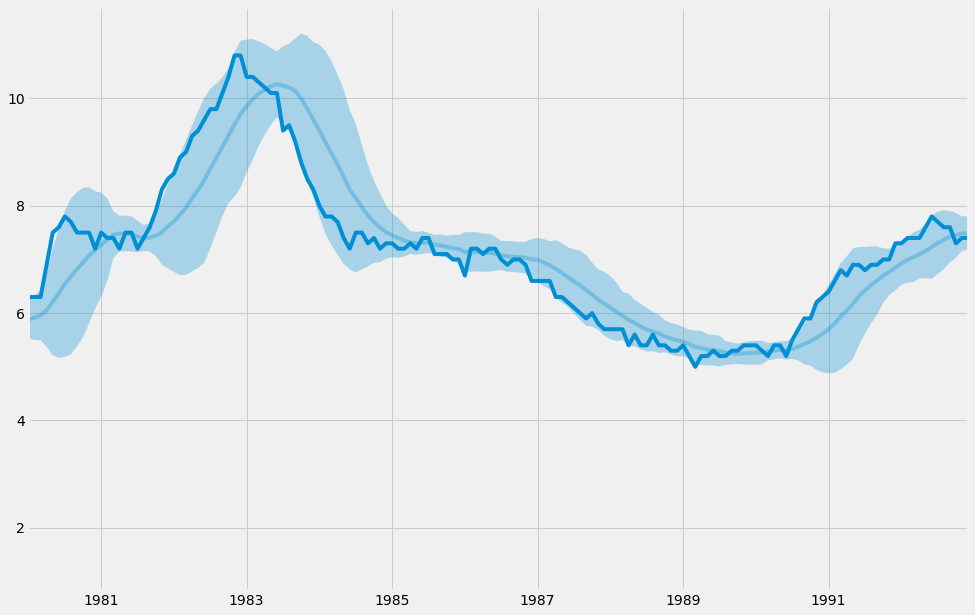

In [7]:
ax = df['rmean']['1980':'1992'].plot(color='C6', alpha=.3)
df['UNRATE']['1980':'1992'].plot()
ax.get_xaxis().label.set_visible(False)
ax.fill_between(df.index, df['lower_band'], df['upper_band'], facecolor='C6', alpha=.3)

The idea is that when the values get outside the band (±Kσ) you should interpret it as a signal. If this were a trading stock it means that when the value gets below the band (-Kσ) and right back up then it's a buy signal. If the value gets above the band (+Kσ) and right back down then it's a sell signal.

So let's keep track of those critical dates:

In [8]:
critical_upper_dates = df.loc[df['UNRATE'] > df['upper_band']].index
critical_lower_dates = df.loc[df['UNRATE'] < df['lower_band']].index

And use them to create 2 lists of critical intervals:

In [9]:
from dateutil.relativedelta import relativedelta

def critical_intervals(critical_dates):
    ret = []
    start = None
    for d in critical_dates:
        if start is None:
            start = d
            end = d
        elif d - relativedelta(months=1) == end:
            end = d
        else:
            ret.append((start, end))
            start = d
            end = d
    ret.append((start, end))
    return ret

critical_upper_intervals = critical_intervals(critical_upper_dates)
critical_lower_intervals = critical_intervals(critical_lower_dates)

So now let's highlight the critical intervals, green for when it goes above the band and red for when it goes below the band.

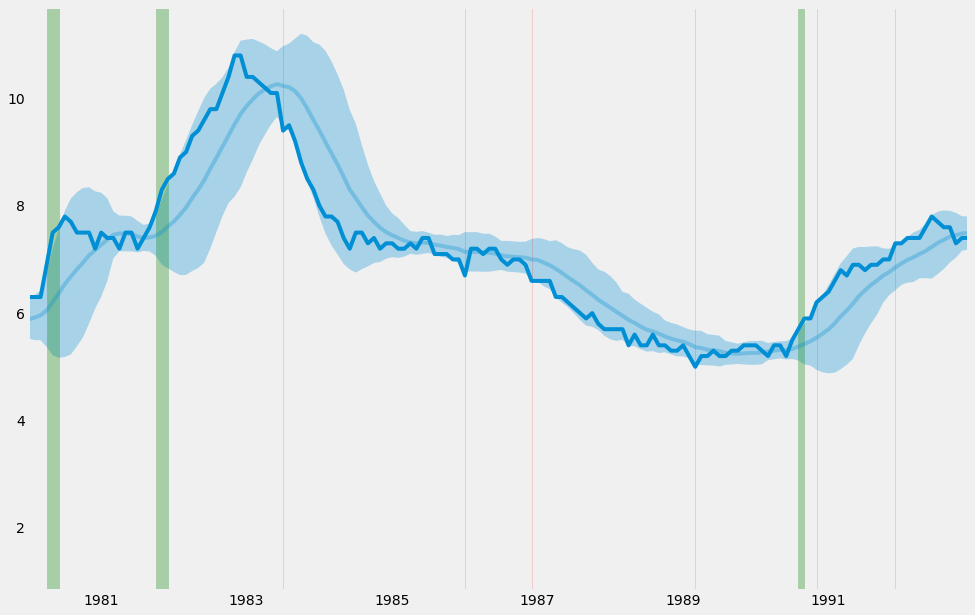

In [10]:
def plot_unrate_with_highlighted_bollinger_bands(date_start=None, date_end=None):
    ax = df['rmean'][date_start:date_end].plot(color='C6', alpha=.3)
    df['UNRATE'][date_start:date_end].plot(color='C6')
    ax.get_xaxis().label.set_visible(False)
    ax.grid(False)
    ax.fill_between(df.index, df['lower_band'], df['upper_band'], alpha=.3)
    for interval in critical_upper_intervals:
        ax.axvspan(*interval, color='green', alpha=.3)
    for interval in critical_lower_intervals:
        ax.axvspan(*interval, color='red', alpha=.3)

plot_unrate_with_highlighted_bollinger_bands('1980', '1992')

Let's look at the 70s (Nixon shock, stagflation!). We got some interesting reds here:

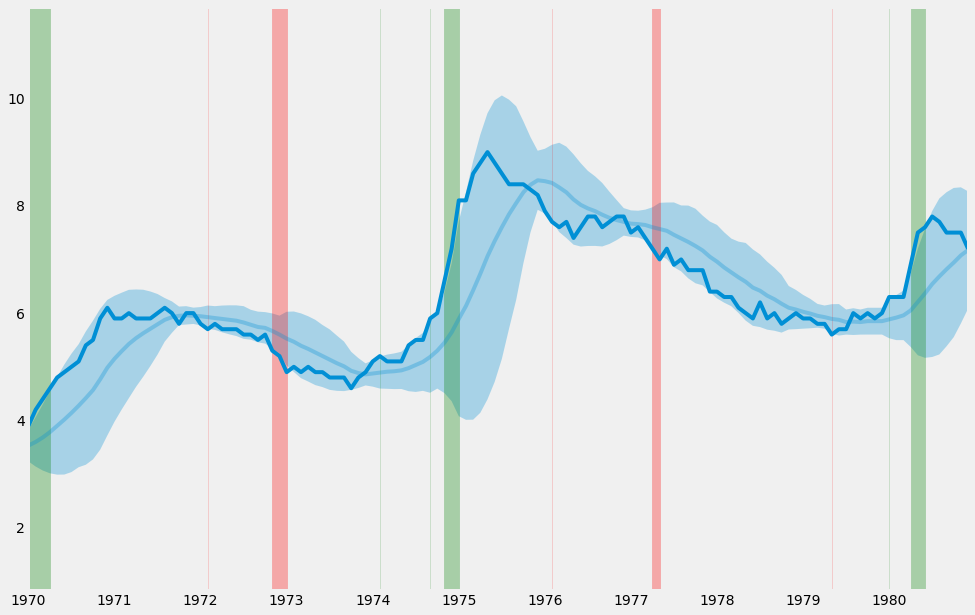

In [11]:
plot_unrate_with_highlighted_bollinger_bands('1970', '1980')

And now let's look at the years around the infamous dotcom bubble... It signalled 8 consecutive reds before it happened. Notice that one green in June 2003, it was a rare example where the Bollinger band signal really worked!

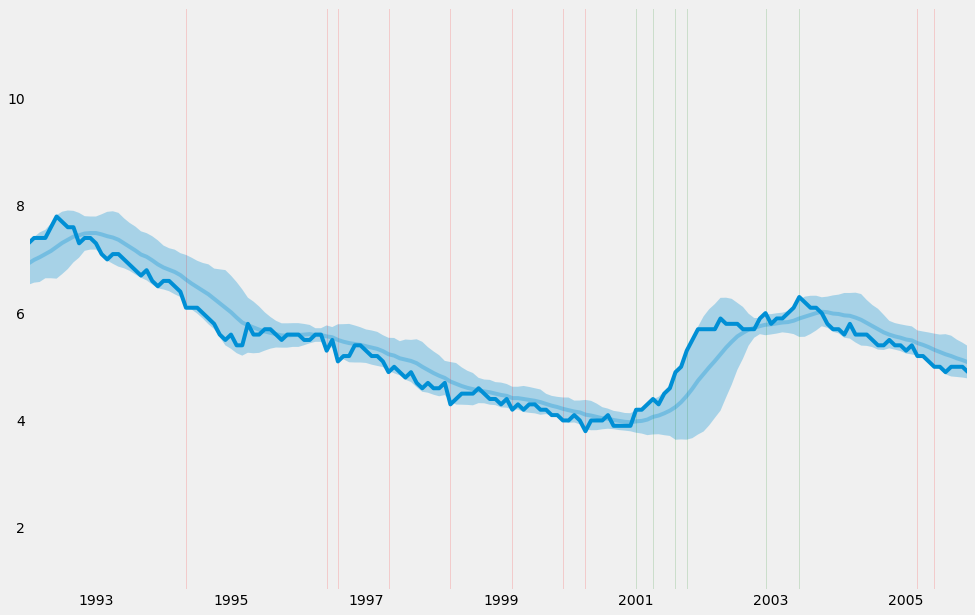

In [12]:
plot_unrate_with_highlighted_bollinger_bands('1992', '2005')

Now let's check the entire graph:

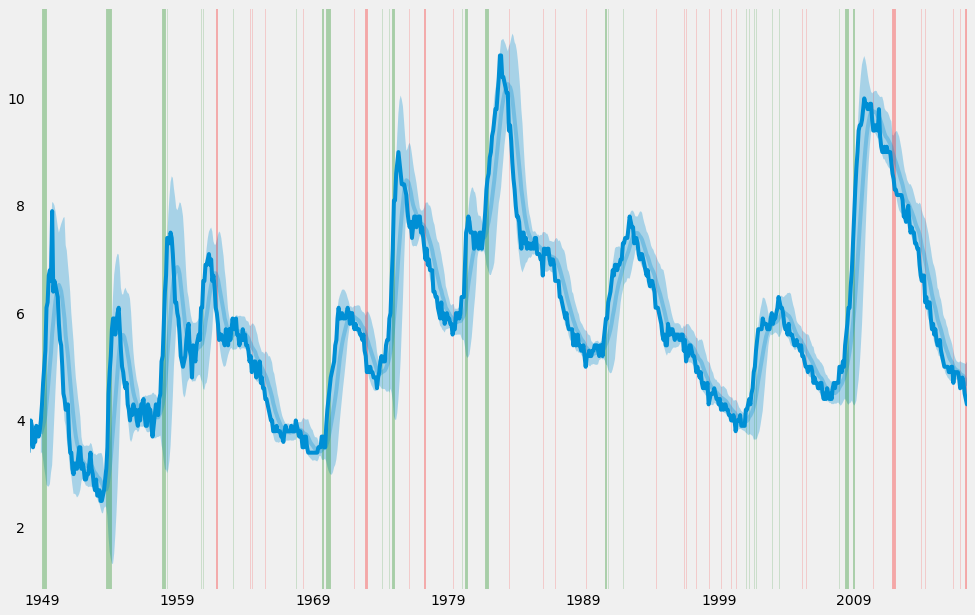

In [13]:
plot_unrate_with_highlighted_bollinger_bands()

Lastly let's focus on the 2008 crash until the present:

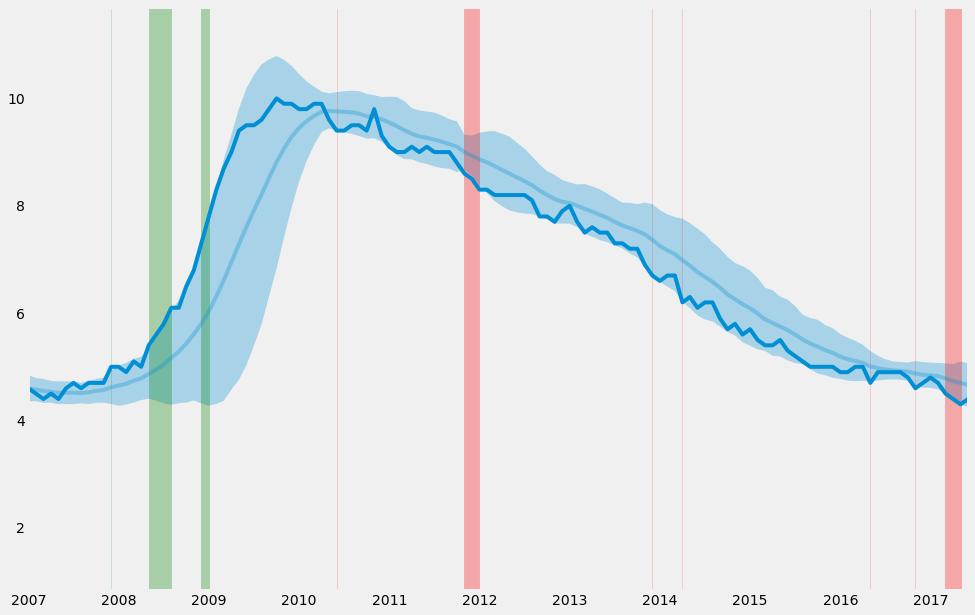

In [14]:
plot_unrate_with_highlighted_bollinger_bands('2007')

So... Are we detecting some signs of rebound? Well, it's hard to say. What we can see here is that unemployment rates are doing *abnormally* well lately!

There was never any other moment in the history before where it hit so many consecutive reds this way, unemployment is decreasing with incessant signals that maybe it's decreasing too fast.

Well, whatever is coming up, I feel like this shows that the US economy (and consequently the world) is going through a special period.